Есть собранная за неделю информация по просмотрам и лайкам пользователей.

In [1]:
import numpy as np
import pandas as pd

views = pd.read_csv('views.csv')
likes = pd.read_csv('likes.csv')

In [2]:
likes.head()

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


In [3]:
views.head()

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


Проверим разбиение групп

Проверка на однозначное соответствие.

In [4]:
tmp = views.groupby('user_id').exp_group.nunique().reset_index()
tmp[tmp.exp_group > 1]

,user_id,exp_group
10071,25623,2
20633,55788,2
54475,142283,2
57065,148670,2


Повторяются 4 пользователя, удалим их

In [5]:
bad_users = tmp[tmp.exp_group > 1].user_id.values

views = views[~np.in1d(views.user_id, bad_users)]
likes = likes[~np.in1d(likes.user_id, bad_users)]

Проверим, что группы разбились нормально

In [6]:
views.groupby('user_id').first().exp_group.value_counts()

test       32659
control    32350
Name: exp_group, dtype: int64

Проверим, улучшились ли  метрики в тестовой группе.

Посчитаем долю пользователей, которая сделала хотя бы один лайк за время эксперимента без разбивки на группы.

Соберём разбиение на группы

In [7]:
groups = views.groupby('user_id').first().reset_index()[['user_id', 'exp_group']]
groups.head()

,user_id,exp_group
0,200,test
1,201,test
2,202,test
3,212,test
4,213,test


Посчитаем число лайков на пользователя

In [8]:
users_w_likes = (
    likes
    .groupby('user_id')
    .post_id.count()
    .reset_index()
    .rename(columns={'post_id': 'like_num'})
)
users_w_likes.head()

,user_id,like_num
0,200,1
1,201,3
2,202,2
3,212,4
4,213,7


In [9]:
tmp = pd.merge(groups, users_w_likes, on='user_id', how='left')
tmp.like_num = tmp.like_num.fillna(0)
tmp['has_like'] = (tmp['like_num'] > 0).astype(int)

In [10]:
tmp.groupby('exp_group')[['has_like', 'like_num']].mean()

,has_like,like_num
exp_group,,
control,0.891314,3.487079
test,0.898160,3.592578


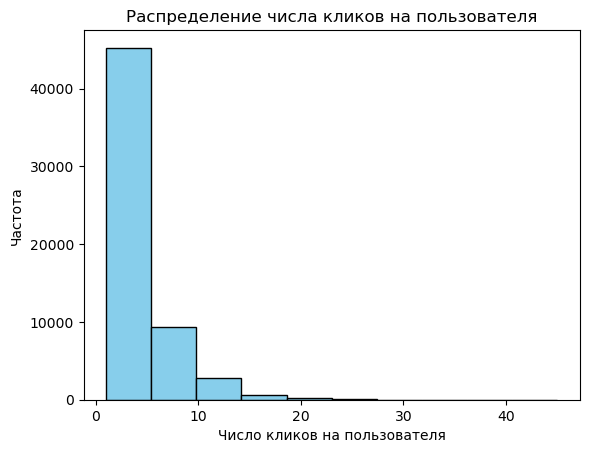

In [11]:
import matplotlib.pyplot as plt

clicks_per_user = users_w_likes.like_num

plt.hist(clicks_per_user, bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Число кликов на пользователя')
plt.ylabel('Частота')
plt.title('Распределение числа кликов на пользователя')

plt.show()

Число кликов на пользователя распределено логнормально. Воспользуемся непараметрическим критерием Манна-Уитни-Уилкоксона.

In [12]:
from scipy.stats import mannwhitneyu

mannwhitneyu(
    tmp[tmp.exp_group == 'control'].like_num,
    tmp[tmp.exp_group == 'test'].like_num,
)

MannwhitneyuResult(statistic=518358073.0, pvalue=2.9585062792441964e-05)

Получили значимые изменения.
Посчитаем hitrate (или долю рекомендаций, в которые пользователи кликнули)

In [13]:
tmp = pd.merge(views, likes, on='user_id', how='outer')
tmp.post_id = tmp.post_id.fillna(-1).astype(int)

Распарсим показы

In [14]:
tmp['recommendations'] = tmp.recommendations.apply(
    lambda x: list(map(int, filter(bool, x[1:-1].split(' '))))
)

Пробежимся по всем показам и сравним с лайками. Пометим то, что является слишком старым или из будущего, лайки по непоказанным рекомендациям

In [15]:
tmp.post_id = tmp.apply(
    lambda row:
    -1
    if
        (row.post_id == -1) | 
        ((row.timestamp_x > row.timestamp_y) |
         (row.timestamp_x + 60 * 60 < row.timestamp_y)) |
        (row.post_id not in row.recommendations)
    else
    row.post_id, axis=1)

Сравним размерности (предполагаем, что таймстемпы показов у пользователей были уникальны)

In [16]:
len(views), len(tmp)

(193268, 1016889)

In [17]:
views.groupby(['user_id', 'timestamp']).first().shape

(193268, 2)

Уникализируем показанные посты

In [18]:
def my_agg(values):
    values = set(values)
    if -1 in values and len(values) >= 2:
        return 1
    elif -1 not in values:
        return 1
    return 0

tmp_agg = tmp.groupby(['user_id', 'exp_group', 'timestamp_x']).post_id.agg(my_agg)

Оценим различие между группами и значимость. 
z-критерий для долей не подходит, так как у нас в каждой выборке один и тот же пользователь может встречаться несколько раз. Применим бакетный подход (то есть перейдём к бакетам и по ним оценим значимость), чтобы поститать групповой hitrate (или CTR) — доля hitrate по группе/бакету. Используем 100 бакетов. Уровень значимости на уровне 0.05.

In [19]:
tmp_agg = tmp_agg.reset_index().rename(columns={'post_id': 'hitrate'})

Подготовим бакеты

In [20]:
import hashlib

tmp_agg['bucket'] = tmp_agg['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'mih').encode()).hexdigest(), 16) % 100
)

In [21]:
tmp_agg['view'] = 1

new_df = tmp_agg.groupby(['exp_group', 'bucket']).sum(['hitrate', 'view']).reset_index()
new_df['hitrate_new'] = new_df.hitrate / new_df.view

new_df.head()

,exp_group,bucket,user_id,timestamp_x,hitrate,view,hitrate_new
0,control,0,83933399,1709217782899,725,1033,0.701839
1,control,1,84545288,1596715255724,691,965,0.716062
2,control,2,73370453,1437870212158,621,869,0.714614
3,control,3,83890595,1659589081667,706,1003,0.703888
4,control,4,79276740,1520594976777,647,919,0.704026


Посчитаем метрику

In [22]:
tmp_agg.groupby('exp_group').hitrate.mean()

exp_group
control    0.706651
test       0.719829
Name: hitrate, dtype: float64

Видно, что разница есть. Оценим ее.

In [23]:
from scipy.stats import mannwhitneyu, ttest_ind

In [24]:
mannwhitneyu(
    new_df[new_df.exp_group == 'control'].hitrate_new,
    new_df[new_df.exp_group == 'test'].hitrate_new,
)

MannwhitneyuResult(statistic=2638.5, pvalue=7.981644143462265e-09)

In [25]:
ttest_ind(
    new_df[new_df.exp_group == 'control'].hitrate_new,
    new_df[new_df.exp_group == 'test'].hitrate_new,
)

Ttest_indResult(statistic=-5.942939632642004, pvalue=1.2430405826083577e-08)

По оценка Манни-Уитни и ttest получили значимую разницу. Значит, можно считать, что новая модель более эффективная.